In [6]:
# Initial imports
import os
import pandas as pd
from newsapi import NewsApiClient
from dotenv import load_dotenv
load_dotenv('config.py.txt')
from pathlib import Path
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import json
from pandas import json_normalize
from ibm_watson import ToneAnalyzerV3
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator

In [7]:

api_key = os.getenv('NEWS_API_KEY')

# Create a newsapi client
newsapi = NewsApiClient(api_key=api_key)

In [8]:
XRP_headlines = newsapi.get_top_headlines(q="xrp", language="en", country="us")
XRP_headlines

{'status': 'ok', 'totalResults': 0, 'articles': []}

In [9]:
print(f"Total articles about XRP: {XRP_headlines['totalResults']}")

# Show sample article
XRP_headlines["articles"][0]

Total articles about XRP: 0


IndexError: list index out of range

In [10]:
XRP_df = pd.DataFrame.from_dict(XRP_headlines["articles"])

XRP_df.head()

""


In [11]:
XRP_headlines_everything = newsapi.get_everything(
    q="XRP", language="en", sort_by="relevancy"
)

# Print total articles
print(f"Total articles about XRP: {XRP_headlines_everything['totalResults']}")

# Show sample article
XRP_headlines_everything["articles"][0]

Total articles about XRP: 458


{'source': {'id': None, 'name': 'Motley Fool'},
 'author': 'newsfeedback@fool.com (Keith Noonan)',
 'title': 'Why XRP (Ripple) Is Soaring Today',
 'description': "The cryptocurrency is making big gains following positive news about Ripple's defense in the SEC lawsuit.",
 'url': 'https://www.fool.com/investing/2022/03/12/why-xrp-is-soaring-today/',
 'urlToImage': 'https://g.foolcdn.com/editorial/images/670282/an-xrp-token-logo.jpg',
 'publishedAt': '2022-03-12T19:23:45Z',
 'content': "What happened\r\nRipple's XRP( XRP -1.34% ) token is making big gains in Saturday's trading. The digital token's price was up roughly 8.3% over the previous 24-hour period as of noon ET Saturday. \r\nXRP… [+1945 chars]"}

In [12]:
XRP_df = pd.DataFrame.from_dict(XRP_headlines_everything["articles"])
XRP_df.head()

,source,author,title,description,url,urlToImage,publishedAt,content
0,"{'id': None, 'name': 'Motley Fool'}",newsfeedback@fool.com (Keith Noonan),Why XRP (Ripple) Is Soaring Today,The cryptocurrency is making big gains followi...,https://www.fool.com/investing/2022/03/12/why-...,https://g.foolcdn.com/editorial/images/670282/...,2022-03-12T19:23:45Z,What happened\r\nRipple's XRP( XRP -1.34% ) to...
1,"{'id': None, 'name': 'Motley Fool'}",newsfeedback@fool.com (Chris MacDonald),"Why XRP, Cardano, and Polkadot Are Surging Hig...","The crypto market is surging, but these three ...",https://www.fool.com/investing/2022/03/28/why-...,https://g.foolcdn.com/editorial/images/672278/...,2022-03-28T17:18:27Z,What happened\r\nToday's surge in valuations a...
2,"{'id': None, 'name': 'ReadWrite'}",Debraj Chatterjee,Rising Blockchain Investments Drive Applicatio...,The continuing integration of technology has b...,https://readwrite.com/rising-blockchain-invest...,https://images.readwrite.com/wp-content/upload...,2022-03-07T15:00:57Z,The continuing integration of technology has b...
3,"{'id': 'the-times-of-india', 'name': 'The Time...",Pawan Nahar,"Bitcoin, Dogecoin, Shiba Inu, Terra tumble up ...","All of the top digital tokens were bleeding, w...",https://economictimes.indiatimes.com/markets/c...,"https://img.etimg.com/thumb/msid-90042705,widt...",2022-03-07T03:46:02Z,New Delhi: Major cryptocurrencies continued to...
4,"{'id': None, 'name': 'Forbes'}","John Navin, Contributor, \n John Navin, Contri...",Big Cryptocurrencies Hold Price Support Levels...,"Bitcoin, Ethereum and XRP managed to hold abov...",https://www.forbes.com/sites/johnnavin/2022/03...,https://imageio.forbes.com/specials-images/ima...,2022-03-27T14:24:18Z,"Montreal, Canada - 28 February 2018: Stacked c..."


# Sentiment Analysis #

In [13]:
nltk.download('vader_lexicon')

# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/cliffordcharles/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [14]:
XRP_sentiments = []

for article in XRP_headlines_everything["articles"]:
    try:
        text = article["content"]
        date = article["publishedAt"][:10]
        sentiment = analyzer.polarity_scores(text)
        compound = sentiment["compound"]
        pos = sentiment["pos"]
        neu = sentiment["neu"]
        neg = sentiment["neg"]
        
        XRP_sentiments.append({
            "text": text,
            "date": date,
            "compound": compound,
            "positive": pos,
            "negative": neg,
            "neutral": neu
            
        })
        
    except AttributeError:
        pass
    
# Create DataFrame
XRP_df_sentiment = pd.DataFrame(XRP_sentiments)

# Reorder DataFrame columns
#cols = ["date", "text", "compound", "positive", "negative", "neutral"]
#XRP_df_sentiment = XRP_sentiments[cols]

XRP_df_sentiment.head()



,text,date,compound,positive,negative,neutral
0,What happened\r\nRipple's XRP( XRP -1.34% ) to...,2022-03-12,0.3400,0.066,0.000,0.934
1,What happened\r\nToday's surge in valuations a...,2022-03-28,0.7717,0.240,0.051,0.709
2,The continuing integration of technology has b...,2022-03-07,0.0571,0.166,0.131,0.703
3,New Delhi: Major cryptocurrencies continued to...,2022-03-07,-0.8748,0.066,0.294,0.639
4,"Montreal, Canada - 28 February 2018: Stacked c...",2022-03-27,0.4019,0.085,0.000,0.915


In [15]:
XRP_df_sentiment.describe()

,compound,positive,negative,neutral
count,20.000000,20.000000,20.000000,20.00000
mean,0.050900,0.073900,0.073100,0.85300
std,0.475172,0.063059,0.103081,0.11038
min,-0.874800,0.000000,0.000000,0.63900
25%,0.000000,0.037500,0.000000,0.74250
50%,0.177900,0.066000,0.020500,0.88900
75%,0.355475,0.098000,0.128000,0.93475
max,0.771700,0.240000,0.304000,1.00000


<AxesSubplot:>

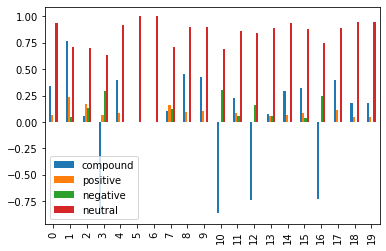

In [16]:
XRP_df_sentiment.plot(kind='bar')